# Sparse Probit Demo

In this demo, we illustrate how to use the `vampyre` package for a simple generalized linear model (GLM).   We build on the [sparse linear inverse demo](sparse_lin_inverse.ipynb) and consider the problem of recovering a sparse vector $z_0$ from binary measurements of the form:  
$$
    y = \mbox{sign}(z_1), \quad z_1 = Az_0 + w,
$$
where $w$ is Gaussian noise.  This is similar to the linear inverse problem considered in the [sparse linear inverse demo](sparse_lin_inverse.ipynb), except that we have added a nonlinear output.  In statistics, this model is known as a Generalized Linear Model or GLM.  The specific form here arises in *sparse probit classification*, where $y$ is a vector of binary class labels $y$, $A$ is a data matrix and $z_0$ is a set of coefficients in the model.  The problem is alse used in de-quantization problems in signal processing.  The particular parameters in this demo were taken from:

* Schniter, Philip, Sundeep Rangan, and Alyson K. Fletcher. "Vector Approximate Message Passing for the Generalized Linear Model." arXiv preprint arXiv:1612.01186 (2016).

In this demo, you will learn to
* Generate synthetic data for a GLM
* Set up a GLM as a type of multi-layer network
* Use the multi-layer VAMP method to perform the GLM estimation
* Handle multi-column data.

## Importing the Package 


We first import the `vampyre` and other packages as in the [sparse linear inverse demo](sparse_lin_inverse.ipynb).

In [1]:
# Add the vampyre path to the system path
import os
import sys
vp_path = os.path.abspath('../../')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp

# Load the other packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Generating Synthetic Data

We next generate synthetic data.  In this case, we will use multi-column data.  First, we set the dimensions.

In [2]:
# Parameters
nz0 = 512   # number of components per column of z0
nz1 = 4096  # number of components per column of z1
ncol = 10   # number of columns

# Compute the shapes
zshape0 = (nz0,ncol)   # Shape of z0 matrix
zshape1 = (nz1,ncol)   # Shape of z1 matrix
Ashape = (nz1,nz0)   # Shape of A matrix

Next, simliar to the [sparse linear inverse demo](sparse_lin_inverse.ipynb), we create Bernoull-Gaussian data.  

In [3]:
# Paramaeters
sparse_rat = 0.1   # sparsity ratio
zmean_act = 0      # mean for the active components
zvar_act = 1       # variance for the active components
snr = 30           # SNR in dB

# Generate the random input
z0 = np.random.normal(zmean_act, np.sqrt(zvar_act), zshape0)
u = np.random.uniform(0, 1, zshape0) < sparse_rat
z0 = z0*u

Now, we create a random transform $A$ and output $z_1 = Az_0 + w$.

In [4]:
# Random transform
b = np.zeros(zshape1)
A = np.random.normal(0, 1/np.sqrt(nz0), Ashape)
Az0 = A.dot(z0)

# Add noise
wvar = np.mean(np.abs(Az0)**2)*np.power(10, -0.1*snr)
z1 = Az0 + np.random.normal(0,np.sqrt(wvar), zshape1)

# Quantize
thresh = 0
y = (z1 > thresh)

## Representing the GLM as a Multi-Layer Network

In the `vampyre` package, we represent the GLM as a special case of *multi-layer* network.  Specifically, the joint density of the output $y$ and intermediate variables $z_0$ and $z_1$ has a factorizable structure as:
$$
    p(z_0,z_1,y) = p(z_0)p(z_1|z_0)p(y|z_1).
$$
We represent each of the three terms in the factorization with an estimator:
* $p(z_0)$:  This is the BG prior on $z_0$ and will be represented by the estimator `est_in`.
* $p(z_1|z_0)$:  This is the conditional density representing the linear mapping $z_1 = Az_0 + w$ and will be represented by the estimator `est_trans`.
* $p(y|z_1)$:  This is the output from the hard-thresholding, $y= \mbox{sign}(z_1)$ and is represented by the estimator `est_out`.

In [5]:
# Create estimator for the input prior
map_est = False
est0_gauss = vp.estim.GaussEst(zmean_act,zvar_act,zshape0,map_est=map_est)
est0_dis = vp.estim.DiscreteEst(0,1,zshape0)
est_in = vp.estim.MixEst([est0_gauss,est0_dis],[sparse_rat,1-sparse_rat])

# Estimator for the output
est_out = vp.estim.HardThreshEst(y,zshape1,thresh=thresh)

# Estimtor for the linear transform
Aop = vp.trans.MatrixLT(A,zshape0)
est_lin = vp.estim.LinEstimTwo(Aop,b,wvar)

# Put all estimators in a list
est_list = [est_in,est_lin,est_out]
    

We next create a list of message handlers, one for each of the two unknown variables, `z0` and `z1`.  Again, we will just use the simple message handlers.

In [6]:
# Create the message handlers
damp=0.95
msg_hdl0 = vp.estim.MsgHdlSimp(map_est=map_est, shape=zshape0,damp=damp) 
msg_hdl1 = vp.estim.MsgHdlSimp(map_est=map_est, shape=zshape1,damp=damp) 

# Put the handlers in a list
msg_hdl_list  = [msg_hdl0,msg_hdl1]

## Running the Multi-Layer VAMP Solver

Having described the input and output estimators and the variance handler, we can now construct a ML-VAMP solver.   The construtor takes the list of estimators, `est_list`, list of message handlers, `msg_hdl_list`.  Also, similar to VAMP, the solver takes a history list `hist_list` and number of iterations `nit`.

In [7]:
nit = 10  # number of iterations
solver = solver = vp.solver.MLVamp(est_list,msg_hdl_list,comp_cost=True,\
        hist_list=['zhat','zhatvar'],nit=nit)

We now run the solver by calling the `solve()` method.  For a small problem like this, this should be close to instantaneous.  

In [8]:
solver.solve()

The VAMP solver estimate is the field `zhat`.  Since there are two variables, `zhat` is a list. We extract the estimate `zhat0=zhat[0]` for `z0`.  Then, we plot the first column (`icol=0`) of the true data and estimate.

[0, 512, -3, 3]

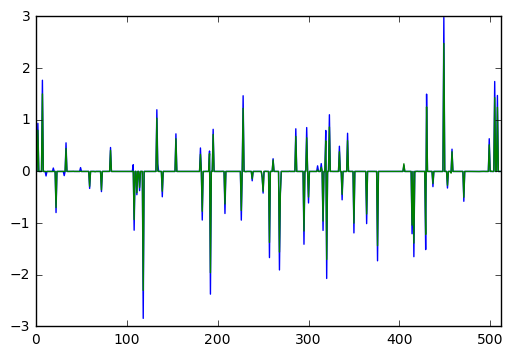

In [9]:
zhat = solver.zhat
zhat0 = zhat[0]
icol = 0   # column to plot
t = np.array(range(nz0))
plt.plot(t,z0[:,icol])
plt.plot(t,zhat0[:,icol])
plt.axis([0,nz0,-3,3])

Since the probit measurement model is invariant to the scaling of vector `z0`, we measure errors via a debiased normalized MSE computed with the following function.

In [10]:
def debias_mse(zhat,ztrue):
    """
    If zhat and ztrue are 1D vectors, the function computes the *debiased normalized MSE* defined as:
    
        dmse_lin = min_c ||ztrue-c*zhat||^2/||ztrue||^2 = (1-|zhat'*ztrue|^2/||ztrue||^2||zhat||^2)
        
    The function returns the value in dB:  dmse = 10*log10(dmse_lin)
    
    If zhat and ztrue are matrices, dmse_lin is computed for each column and then averaged over the columns
    """
    zcorr = np.abs(np.sum(zhat.conj()*ztrue,axis=0))**2
    zhatpow = np.sum(np.abs(zhat)**2,axis=0)
    zpow = np.sum(np.abs(ztrue)**2,axis=0)
    tol = 1e-8
    if np.any(zhatpow < tol) or np.any(zpow < tol):
        dmse = 0
    else:
        dmse = 10*np.log10(np.mean(1 - zcorr/zhatpow/zpow))
    return dmse    

We can then measure the debiased normalized MSE of the estimate.

In [12]:
ztrue = [z0,z1]
zhat = solver.zhat
nvar = len(ztrue)
dmse = np.zeros(nvar)
for i in range(nvar):
    zhati = zhat[i]
    ztruei = ztrue[i]
    dmse[i] = debias_mse(zhati,ztruei)
    print("z{0:d} d-MSE: {1:7.2f}".format(i, dmse[i]))

z0 d-MSE:  -29.78
z1 d-MSE:  -26.87


Finally, we can plot the actual and predicted debiased MSE as a function of the iteration number.  When `solver` was contructed, we passed an argument `hist_list=['zhat', 'zhatvar']`.  This indicated to store the value of the estimate `zhat` and predicted error variance `zhatvar` with each iteration.  We can recover these values from `solver.hist_dict`, the history dictionary.   We then plot the predicted and actual MSE for each of the two variables.  We see that the two match well.  Also, the iterations are indexed as "half-iterations" since each iteration takes two passes.

Note that in the multi-column data, the variance at each iteration, `zhatvari`, is a vector with one predicted variance per column.  The MLVAMP method can be adjusted to average the variance over all the columns, but this generally leads to poorer or even unstable performance.

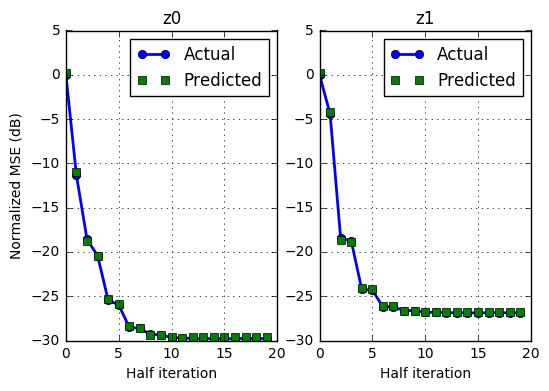

In [13]:
# Compute the MSE as a function of the iteration
zhat_hist = solver.hist_dict['zhat']
zvar_hist = solver.hist_dict['zhatvar']
nit = len(zhat_hist)
mse_act = np.zeros((nit,nvar))
mse_pred = np.zeros((nit,nvar))
 
for ivar in range(nvar): 
    zpowi = np.mean(np.abs(ztrue[ivar])**2, axis=0)
    for it in range(nit):
        zhati = zhat_hist[it][ivar]
        zhatvari = zvar_hist[it][ivar]
        mse_act[it,ivar] = debias_mse(zhati,ztrue[ivar])
        mse_pred[it,ivar] = 10*np.log10(np.mean(zhatvari/zpowi))

for ivar in range(nvar):
    plt.subplot(1,nvar,ivar+1)
    plt.plot(range(nit), mse_act[:,ivar], 'o-', linewidth=2)
    plt.plot(range(nit), mse_pred[:,ivar], 's', linewidth=1)
    plt.xlabel('Half iteration')
    if (ivar == 0):
        plt.ylabel('Normalized MSE (dB)')
    plt.legend(['Actual', 'Predicted'])
    plt.title("z{0:d}".format(ivar))
    plt.grid()
    